In [21]:
# STEP 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prophet import Prophet

import datetime as dt
import warnings
warnings.filterwarnings("ignore")

" Libraries imported successfully."


' Libraries imported successfully.'

In [22]:
# STEP 2: Load and Inspect Datasets

# Load all three CSVs
fulfillment_df = pd.read_csv("./docs/fulfillment.csv")
inventory_df = pd.read_csv("./docs/inventory.csv")
orders_df = pd.read_csv("./docs/orders_and_shipments.csv")

# Display the first few rows of each DataFrame
print("Fulfillment DataFrame:")
display(fulfillment_df.head())
print("\nInventory DataFrame:")
display(inventory_df.head())
print("\nOrders DataFrame:")
display(orders_df.head())


Fulfillment DataFrame:
                                    Product Name  \
0               Perfect Fitness Perfect Rip Deck   
1           Nike Men's Dri-FIT Victory Golf Polo   
2               O'Brien Men's Neoprene Life Vest   
3              Nike Men's Free 5.0+ Running Shoe   
4  Under Armour Girls' Toddler Spine Surge Runni   

    Warehouse Order Fulfillment (days)   
0                                   8.3  
1                                   6.6  
2                                   5.5  
3                                   9.4  
4                                   6.3  

Inventory DataFrame:
                                    Product Name   Year Month   \
0               Perfect Fitness Perfect Rip Deck        201712   
1           Nike Men's Dri-FIT Victory Golf Polo        201712   
2               O'Brien Men's Neoprene Life Vest        201712   
3              Nike Men's Free 5.0+ Running Shoe        201712   
4  Under Armour Girls' Toddler Spine Surge Runni        2017

# Step 1: Data Cleaning & Preparation

In [23]:
import pandas as pd

# Load CSVs
orders_df = pd.read_csv("./docs/orders_and_shipments.csv")
inventory_df = pd.read_csv("./docs/inventory.csv")
fulfillment_df = pd.read_csv("./docs/fulfillment.csv")

# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

# Clean all datasets
orders_df = clean_column_names(orders_df)
inventory_df = clean_column_names(inventory_df)
fulfillment_df = clean_column_names(fulfillment_df)

# Fix discount_%: clean and convert to float
orders_df['discount_%'] = orders_df['discount_%'].astype(str).str.strip().replace({'-': '0', '': '0'}).astype(float)

# Create datetime column from year/month/day
orders_df['order_date'] = pd.to_datetime(
    orders_df[['order_year', 'order_month', 'order_day']].rename(
        columns={"order_year": "year", "order_month": "month", "order_day": "day"}
    )
)

# Create merge keys
orders_df['yearmonth_str'] = orders_df['order_yearmonth'].astype(str)
inventory_df['yearmonth_str'] = inventory_df['year_month'].astype(str)

# Final preview (optional – for debugging)
print(" Orders Data (Cleaned):")
display(orders_df[['order_id', 'product_name', 'order_quantity', 'order_date', 'discount_%']].head())

print("\n Inventory Data (Cleaned):")
display(inventory_df[['product_name', 'warehouse_inventory', 'inventory_cost_per_unit', 'yearmonth_str']].head())

print("\n Fulfillment Data (Cleaned):")
display(fulfillment_df.head())


 Orders Data (Cleaned):
   order_id                               product_name  order_quantity  \
0      3535  Field & Stream Sportsman 16 Gun Fire Safe               1   
1      4133  Field & Stream Sportsman 16 Gun Fire Safe               1   
2      7396  Field & Stream Sportsman 16 Gun Fire Safe               1   
3     11026  Field & Stream Sportsman 16 Gun Fire Safe               1   
4     11026  Field & Stream Sportsman 16 Gun Fire Safe               1   

  order_date  discount_%  
0 2015-02-21        0.25  
1 2015-03-02        0.09  
2 2015-04-18        0.06  
3 2015-06-10        0.15  
4 2015-06-10        0.13  

 Inventory Data (Cleaned):
                                    product_name  warehouse_inventory  \
0               Perfect Fitness Perfect Rip Deck                    0   
1           Nike Men's Dri-FIT Victory Golf Polo                    2   
2               O'Brien Men's Neoprene Life Vest                    0   
3              Nike Men's Free 5.0+ Running Shoe 

In [ ]:
#  Save cleaned datasets
orders_df.to_csv("cleaned_orders.csv", index=False)
inventory_df.to_csv("cleaned_inventory.csv", index=False)
fulfillment_df.to_csv("cleaned_fulfillment.csv", index=False)

#  Step 2: Merge Cleaned Datasets

In [26]:
import pandas as pd

# Load cleaned datasets from Step 1
orders_df = pd.read_csv("cleaned_orders.csv")
inventory_df = pd.read_csv("cleaned_inventory.csv")
fulfillment_df = pd.read_csv("cleaned_fulfillment.csv")

# Merge 1: Add fulfillment info (on Product Name)
merged_df = pd.merge(
    orders_df,
    fulfillment_df,
    how='left',
    on='product_name'
)

# Merge 2: Add inventory info (on Product Name + YearMonth)
merged_df = pd.merge(
    merged_df,
    inventory_df,
    how='left',
    on=['product_name', 'yearmonth_str']
)

# Preview merged data
print(" Merged Dataset (Top 5 rows):")
print(merged_df[['order_id', 'product_name', 'order_quantity', 'order_date',
                 'warehouse_inventory', 'warehouse_order_fulfillment_(days)']].head())

# Save final merged dataset for modeling
merged_df.to_csv("final_merged_dataset.csv", index=False)
print("\n Final merged dataset saved as 'final_merged_dataset.csv'")
# Final preview of merged dataset
print(" Merged Dataset (Top 5 rows):")
display(merged_df[['order_id', 'product_name', 'order_quantity', 'order_date',
                 'warehouse_inventory', 'warehouse_order_fulfillment_(days)']].head())
# Save final merged dataset for modeling
merged_df.to_csv("final_merged_dataset.csv", index=False)


 Merged Dataset (Top 5 rows):
   order_id                               product_name  order_quantity  \
0      3535  Field & Stream Sportsman 16 Gun Fire Safe               1   
1      4133  Field & Stream Sportsman 16 Gun Fire Safe               1   
2      7396  Field & Stream Sportsman 16 Gun Fire Safe               1   
3     11026  Field & Stream Sportsman 16 Gun Fire Safe               1   
4     11026  Field & Stream Sportsman 16 Gun Fire Safe               1   

   order_date  warehouse_inventory  warehouse_order_fulfillment_(days)  
0  2015-02-21                    7                                 4.9  
1  2015-03-02                  153                                 4.9  
2  2015-04-18                   73                                 4.9  
3  2015-06-10                   76                                 4.9  
4  2015-06-10                   76                                 4.9  

 Final merged dataset saved as 'final_merged_dataset.csv'
 Merged Dataset (Top 5 rows)


 Running EDA on merged dataset...

 Missing values:
 order_id                              0
order_item_id                         0
order_yearmonth                       0
order_year                            0
order_month                           0
order_day                             0
order_time                            0
order_quantity                        0
product_department                    0
product_category                      0
product_name                          0
customer_id                           0
customer_market                       0
customer_region                       0
customer_country                      0
warehouse_country                     0
shipment_year                         0
shipment_month                        0
shipment_day                          0
shipment_mode                         0
shipment_days_-_scheduled             0
gross_sales                           0
discount_%                            0
profit                    

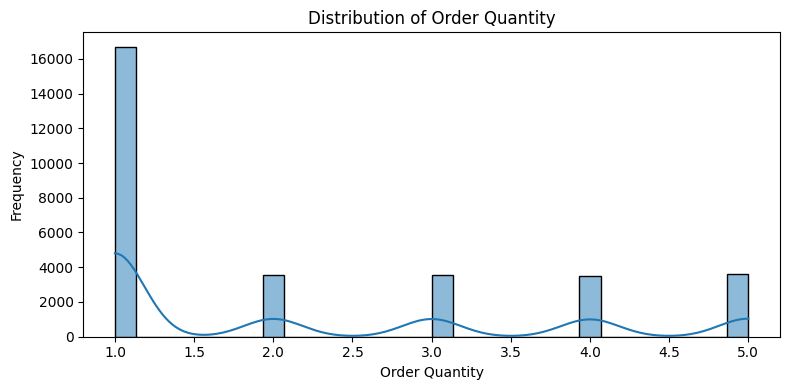

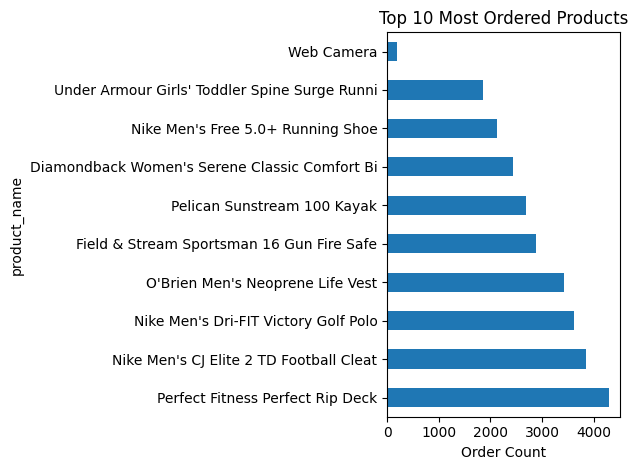

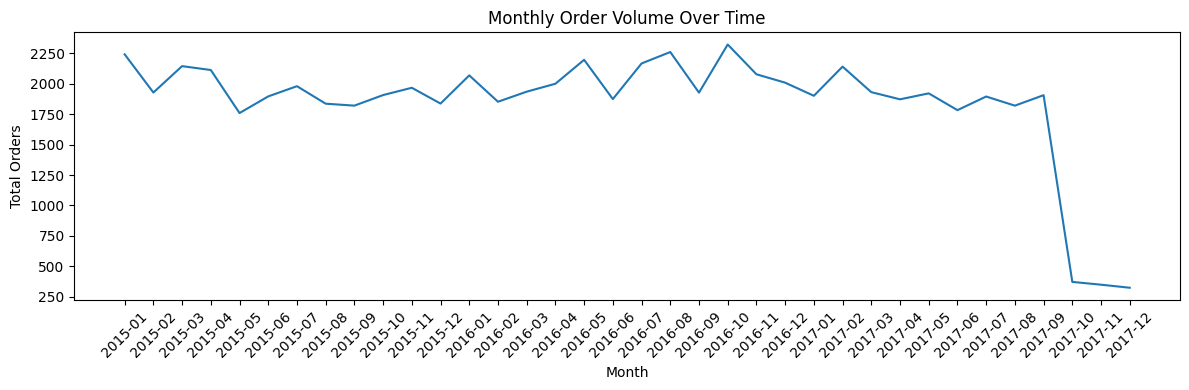

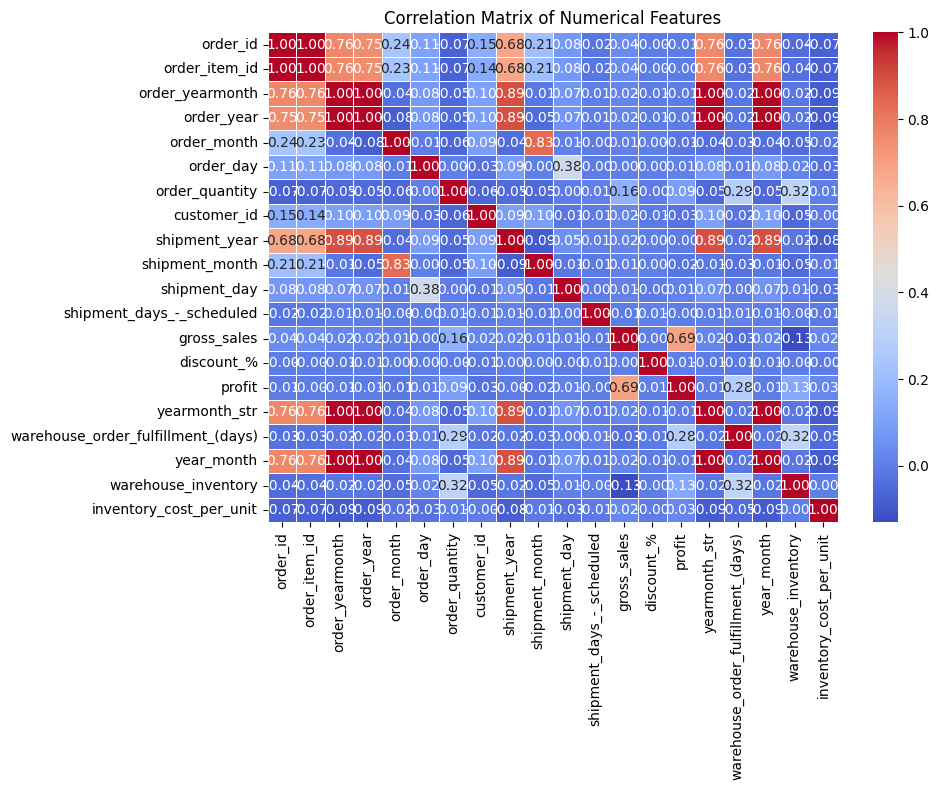

In [37]:
# --------------------------------------
#  EDA Section 
# --------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

print("\n Running EDA on merged dataset...\n")

# 1. Missing values
print(" Missing values:\n", merged_df.isnull().sum())

# 2. Data types
print("\n Data types:\n", merged_df.dtypes)

# 3. Distribution of Order Quantity
plt.figure(figsize=(8, 4))
sns.histplot(merged_df['order_quantity'], bins=30, kde=True)
plt.title("Distribution of Order Quantity")
plt.xlabel("Order Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4. Top 10 Products by Order Volume
top_products = merged_df['product_name'].value_counts().head(10)
top_products.plot(kind='barh', title="Top 10 Most Ordered Products")
plt.xlabel("Order Count")
plt.tight_layout()
plt.show()

# 5. Sales trend over time
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])
monthly_orders = merged_df.groupby(merged_df['order_date'].dt.to_period("M")).agg({'order_quantity': 'sum'}).reset_index()
monthly_orders['order_date'] = monthly_orders['order_date'].astype(str)
plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly_orders, x='order_date', y='order_quantity')
plt.xticks(rotation=45)
plt.title("Monthly Order Volume Over Time")
plt.xlabel("Month")
plt.ylabel("Total Orders")
plt.tight_layout()
plt.show()

# 6.  Correlation Matrix (numerical features)
plt.figure(figsize=(10, 8))
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = merged_df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()



# Step 3: Feature Engineering

In [27]:
import pandas as pd

# Load the merged dataset
df = pd.read_csv("final_merged_dataset.csv")

#  Feature: Extract time-based features from order_date
df['order_date'] = pd.to_datetime(df['order_date'])  # ensure datetime format
df['order_dayofweek'] = df['order_date'].dt.dayofweek
df['order_month'] = df['order_date'].dt.month
df['order_year'] = df['order_date'].dt.year

#  Feature: Calculate shipment delay
df['shipment_date'] = pd.to_datetime(
    dict(year=df['shipment_year'], month=df['shipment_month'], day=df['shipment_day']),
    errors='coerce'
)
df['shipment_delay'] = (df['shipment_date'] - df['order_date']).dt.days

#  Feature: Inventory difference (optional business feature)
df['inventory_diff'] = df['warehouse_inventory'] - df['order_quantity']

# 🔮 Prophet columns
df['ds'] = df['order_date']
df['y'] = df['order_quantity']

#  Optional: Encode categorical features for ML later
df['product_category_encoded'] = df['product_category'].astype('category').cat.codes
df['customer_region_encoded'] = df['customer_region'].astype('category').cat.codes
df['shipment_mode_encoded'] = df['shipment_mode'].astype('category').cat.codes

#  Save engineered dataset
df.to_csv("engineered_dataset.csv", index=False)

#  Preview
print(" Feature Engineering Done. Sample Rows:")
print(df[['ds', 'y', 'order_dayofweek', 'order_month', 'shipment_delay', 'inventory_diff']].head())


 Feature Engineering Done. Sample Rows:
          ds  y  order_dayofweek  order_month  shipment_delay  inventory_diff
0 2015-02-21  1                5            2               6               6
1 2015-03-02  1                0            3               4             152
2 2015-04-18  1                5            4               2              72
3 2015-06-10  1                2            6               2              75
4 2015-06-10  1                2            6               2              75


# Step 4A: Classical ML Modeling

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the engineered dataset
df = pd.read_csv("engineered_dataset.csv")

#  Define target and features
target = 'order_quantity'
features = [
    'order_dayofweek', 'order_month', 'shipment_delay', 'inventory_diff',
    'product_category_encoded', 'customer_region_encoded', 'shipment_mode_encoded'
]

X = df[features]
y = df[target]

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Scale features (especially for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

#  Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

#  Evaluation function
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n {name} Model Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

#  Evaluate both models
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)





 Linear Regression Model Evaluation:
MAE: 1.17
RMSE: 1.38
R² Score: 0.1046

 Random Forest Model Evaluation:
MAE: 0.17
RMSE: 0.45
R² Score: 0.9028


# Step 4B: Prophet Model

17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:30 - cmdstanpy - INFO - Chain [1] done processing


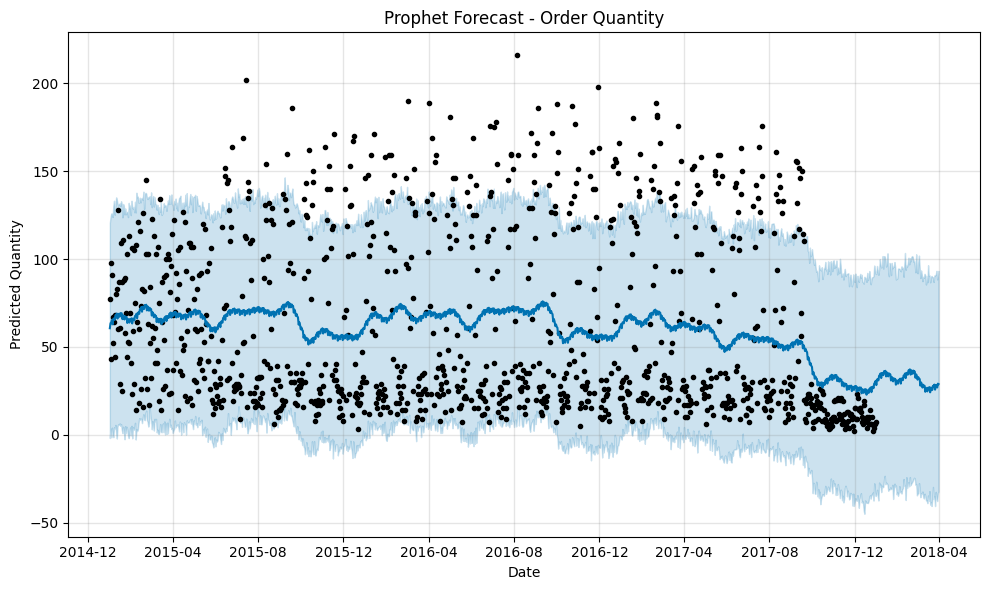

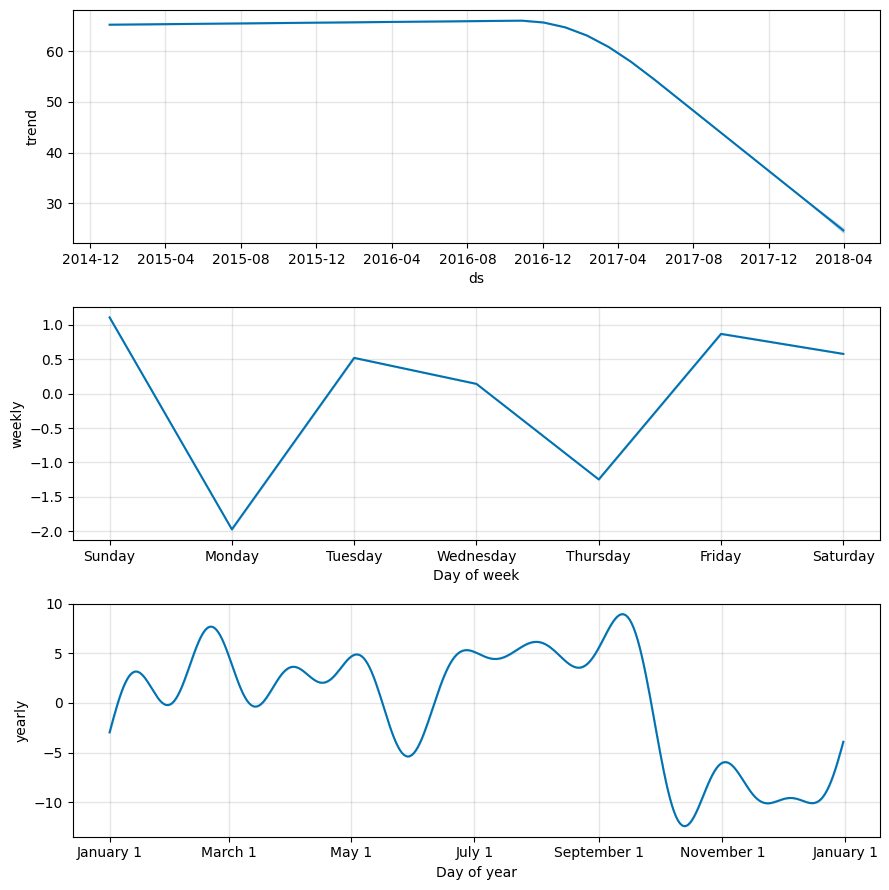

 Prophet forecast saved to 'prophet_forecast.csv'


In [33]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load engineered dataset
df = pd.read_csv("engineered_dataset.csv")

#  Aggregate data by month for forecasting
monthly_df = df.groupby('ds').agg({'y': 'sum'}).reset_index()

#  Initialize and train Prophet model
model = Prophet()
model.fit(monthly_df)

#  Create future dataframe (e.g., forecast for next 3 months)
future = model.make_future_dataframe(periods=90)  # daily granularity
forecast = model.predict(future)

#  Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast - Order Quantity")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity")
plt.tight_layout()
plt.show()

#  Optional: Plot forecast components (trend, weekly, yearly seasonality)
model.plot_components(forecast)
plt.tight_layout()
plt.show()

#  Save forecast to CSV
forecast.to_csv("prophet_forecast.csv", index=False)
print(" Prophet forecast saved to 'prophet_forecast.csv'")


# Step 5: Model Comparison

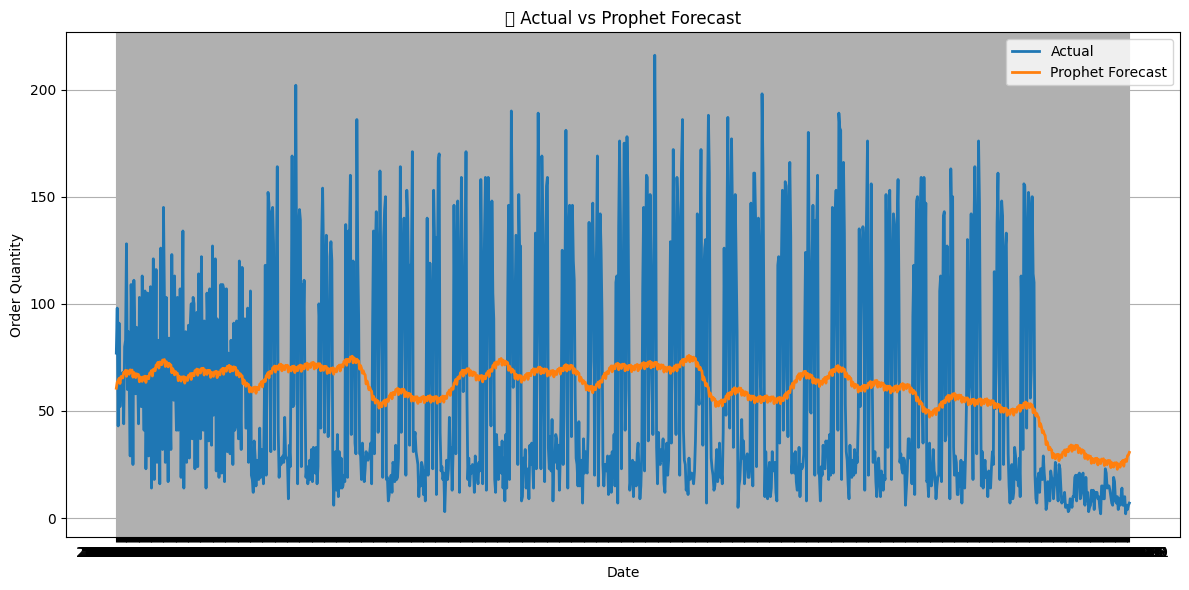

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions and actuals
forecast = pd.read_csv("prophet_forecast.csv")
df = pd.read_csv("engineered_dataset.csv")

# Group actual demand by date for comparison
actual_df = df.groupby('ds').agg({'y': 'sum'}).reset_index()
actual_df.rename(columns={'y': 'actual'}, inplace=True)

# Extract only forecasted dates (excluding training period)
forecast_trimmed = forecast[['ds', 'yhat']].copy()
forecast_trimmed.rename(columns={'yhat': 'forecast'}, inplace=True)

# Merge actuals and Prophet forecast
merged = pd.merge(actual_df, forecast_trimmed, on='ds', how='left')

#  Plot Actual vs Prophet Forecast
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['actual'], label='Actual', linewidth=2)
plt.plot(merged['ds'], merged['forecast'], label='Prophet Forecast', linewidth=2)
plt.title("📊 Actual vs Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()





In [35]:
import pandas as pd

# Load forecast and inventory
forecast = pd.read_csv("prophet_forecast.csv")
inventory = pd.read_csv("cleaned_inventory.csv")

# --- Step 1: Use only future dates from the forecast ---
future_forecast = forecast[forecast['ds'] > '2017-12-31'][['ds', 'yhat']]
future_forecast.rename(columns={'yhat': 'forecasted_demand'}, inplace=True)

# --- Step 2: Simulate current inventory per product (assume static or latest value) ---
# You can also group inventory by product and pick the last month if needed
latest_inventory = inventory.groupby('product_name').agg({'warehouse_inventory': 'mean'}).reset_index()

# For simplicity, let's simulate reorder logic for **one product** across time
# You can loop over products for full automation

# Let's assume 1 product to track
tracked_product = "Perfect Fitness Perfect Rip Deck"
product_inventory = latest_inventory[latest_inventory['product_name'] == tracked_product]['warehouse_inventory'].values[0]

# Add product info & inventory to forecast
future_forecast['product_name'] = tracked_product
future_forecast['current_inventory'] = product_inventory

# --- Step 3: Reorder logic ---
# If forecasted_demand > current_inventory, trigger reorder
BUFFER = 10  # Safety stock

future_forecast['reorder_flag'] = future_forecast['forecasted_demand'] > future_forecast['current_inventory']
future_forecast['reorder_quantity'] = future_forecast.apply(
    lambda row: max(0, round(row['forecasted_demand'] - row['current_inventory'] + BUFFER)) if row['reorder_flag'] else 0,
    axis=1
)

# --- Step 4: Save and Show ---
future_forecast.to_csv("reorder_plan.csv", index=False)

print(" Reorder Plan for Product:", tracked_product)
print(future_forecast[['ds', 'forecasted_demand', 'current_inventory', 'reorder_flag', 'reorder_quantity']].head())






 Reorder Plan for Product: Perfect Fitness Perfect Rip Deck
              ds  forecasted_demand  current_inventory  reorder_flag  \
1096  2018-01-01          28.232798             402.25         False   
1097  2018-01-02          31.386267             402.25         False   
1098  2018-01-03          31.657064             402.25         False   
1099  2018-01-04          30.894767             402.25         False   
1100  2018-01-05          33.607212             402.25         False   

      reorder_quantity  
1096                 0  
1097                 0  
1098                 0  
1099                 0  
1100                 0  


In [36]:
import pandas as pd

# Load forecast and inventory
forecast = pd.read_csv("prophet_forecast.csv")
inventory = pd.read_csv("cleaned_inventory.csv")

# --- Step 1: Use only future forecast dates ---
future_forecast = forecast[forecast['ds'] > '2017-12-31'][['ds', 'yhat']]
future_forecast.rename(columns={'yhat': 'forecasted_demand'}, inplace=True)

# --- Step 2: Prepare reorder buffer ---
BUFFER = 10  # safety stock

# --- Step 3: Prepare full reorder table ---
reorder_results = []

# --- Step 4: Loop through each product ---
for product in inventory['product_name'].unique():
    # Get average inventory for the product
    inventory_value = inventory[inventory['product_name'] == product]['warehouse_inventory'].mean()

    # Copy forecast for this product
    df_product = future_forecast.copy()
    df_product['product_name'] = product
    df_product['current_inventory'] = inventory_value

    # Apply reorder logic
    df_product['reorder_flag'] = df_product['forecasted_demand'] > df_product['current_inventory']
    df_product['reorder_quantity'] = df_product.apply(
        lambda row: max(0, round(row['forecasted_demand'] - row['current_inventory'] + BUFFER)) if row['reorder_flag'] else 0,
        axis=1
    )

    reorder_results.append(df_product)

# --- Step 5: Combine all results ---
reorder_plan_all = pd.concat(reorder_results, ignore_index=True)

# Save to CSV
reorder_plan_all.to_csv("reorder_plan_all_products.csv", index=False)

# Preview
print("✅ Reorder logic applied to all products.")
print(reorder_plan_all.head())


✅ Reorder logic applied to all products.
           ds  forecasted_demand                      product_name  \
0  2018-01-01          28.232798  Perfect Fitness Perfect Rip Deck   
1  2018-01-02          31.386267  Perfect Fitness Perfect Rip Deck   
2  2018-01-03          31.657064  Perfect Fitness Perfect Rip Deck   
3  2018-01-04          30.894767  Perfect Fitness Perfect Rip Deck   
4  2018-01-05          33.607212  Perfect Fitness Perfect Rip Deck   

   current_inventory  reorder_flag  reorder_quantity  
0             402.25         False                 0  
1             402.25         False                 0  
2             402.25         False                 0  
3             402.25         False                 0  
4             402.25         False                 0  
